<a href="https://colab.research.google.com/github/CHENHUI-X/TimeDistributed/blob/main/TimeDistributed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- Here we input a series of pictures and predict what action will be in the next frame

In [ ]:
import os
# --------------------------------------------

if os.path.exists('./seq_prediction'):
  pass 
else :
  os.mkdir('./seq_prediction')

%cd ./seq_prediction

# --------------------------------------------
if os.path.exists('./videos_generate'):
  pass 
else :
  os.mkdir('./videos_generate')
# --------------------------------------------
if os.path.exists('./videos'):
  pass 
else :
  os.mkdir('./videos')


In [12]:
!git init 
!git clone https://github.com/metal3d/keras-video-generators.git

Reinitialized existing Git repository in /content/seq_prediction/.git/
fatal: destination path 'keras-video-generators' already exists and is not an empty directory.


In [42]:

%cd /content/seq_prediction/keras-video-generators/
!python setup.py build 

/content/seq_prediction/keras-video-generators
/usr/lib/python3.7/distutils/dist.py:274: UserWarning: Unknown distribution option: 'licence_file'
  warnings.warn(msg)
running build
running build_py


In [3]:
%cd ./videos_generate
!wget https://serre-lab.clps.brown.edu/wp-content/uploads/2013/10/hmdb51_org.rar


/content/seq_prediction/videos_generate
--2022-08-03 01:05:28--  https://serre-lab.clps.brown.edu/wp-content/uploads/2013/10/hmdb51_org.rar
Resolving serre-lab.clps.brown.edu (serre-lab.clps.brown.edu)... 128.148.254.114
Connecting to serre-lab.clps.brown.edu (serre-lab.clps.brown.edu)|128.148.254.114|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2124008126 (2.0G)
Saving to: ‘hmdb51_org.rar’

hmdb51_org.rar      100%[===================>]   1.98G  45.7MB/s    in 30s     

2022-08-03 01:05:58 (68.6 MB/s) - ‘hmdb51_org.rar’ saved [2124008126/2124008126]



In [4]:
os.listdir()


['hmdb51_org.rar']

In [ ]:
!unrar e hmdb51_org.rar  ./hmdb51_org/

- we just test the idea, so just need 3 calss for train and validation 

In [ ]:
!unrar e ./hmdb51_org/eat.rar  ../videos/eat/
!unrar e ./hmdb51_org/golf.rar  ../videos/golf/
!unrar e ./hmdb51_org/jump.rar  ../videos/jump/

In [45]:

import os
import glob
from tensorflow import keras
# %cd /content/seq_prediction/keras-video-generators/src
from keras_video import VideoFrameGenerator

%cd /content/seq_prediction/
# use sub directories names as classes
classes = [i.split(os.path.sep)[-1] for i in glob.glob('./videos/*')]
print(classes)
classes.sort()
# some global params
SIZE = (112, 112)
CHANNELS = 3
NBFRAME = 5
BS = 8
# pattern to get videos and classes
glob_pattern='./videos/{classname}/*.avi'
# for data augmentation
data_aug = keras.preprocessing.image.ImageDataGenerator(
    zoom_range=.1,
    horizontal_flip=True,
    rotation_range=8,
    width_shift_range=.2,
    height_shift_range=.2)
# Create video frame generator
train = VideoFrameGenerator(
    classes=classes, 
    glob_pattern=glob_pattern,
    nb_frames=NBFRAME,
    split=.33, 
    shuffle=True,
    batch_size=BS,
    target_shape=SIZE,
    nb_channel=CHANNELS,
    transformation=data_aug,
    use_frame_cache=True)

valid = train.get_validation_generator()

/content/seq_prediction
['eat', 'jump', 'golf']
Total data: 3 classes for 364 files for train
Total data: 3 classes for 0 files for validation


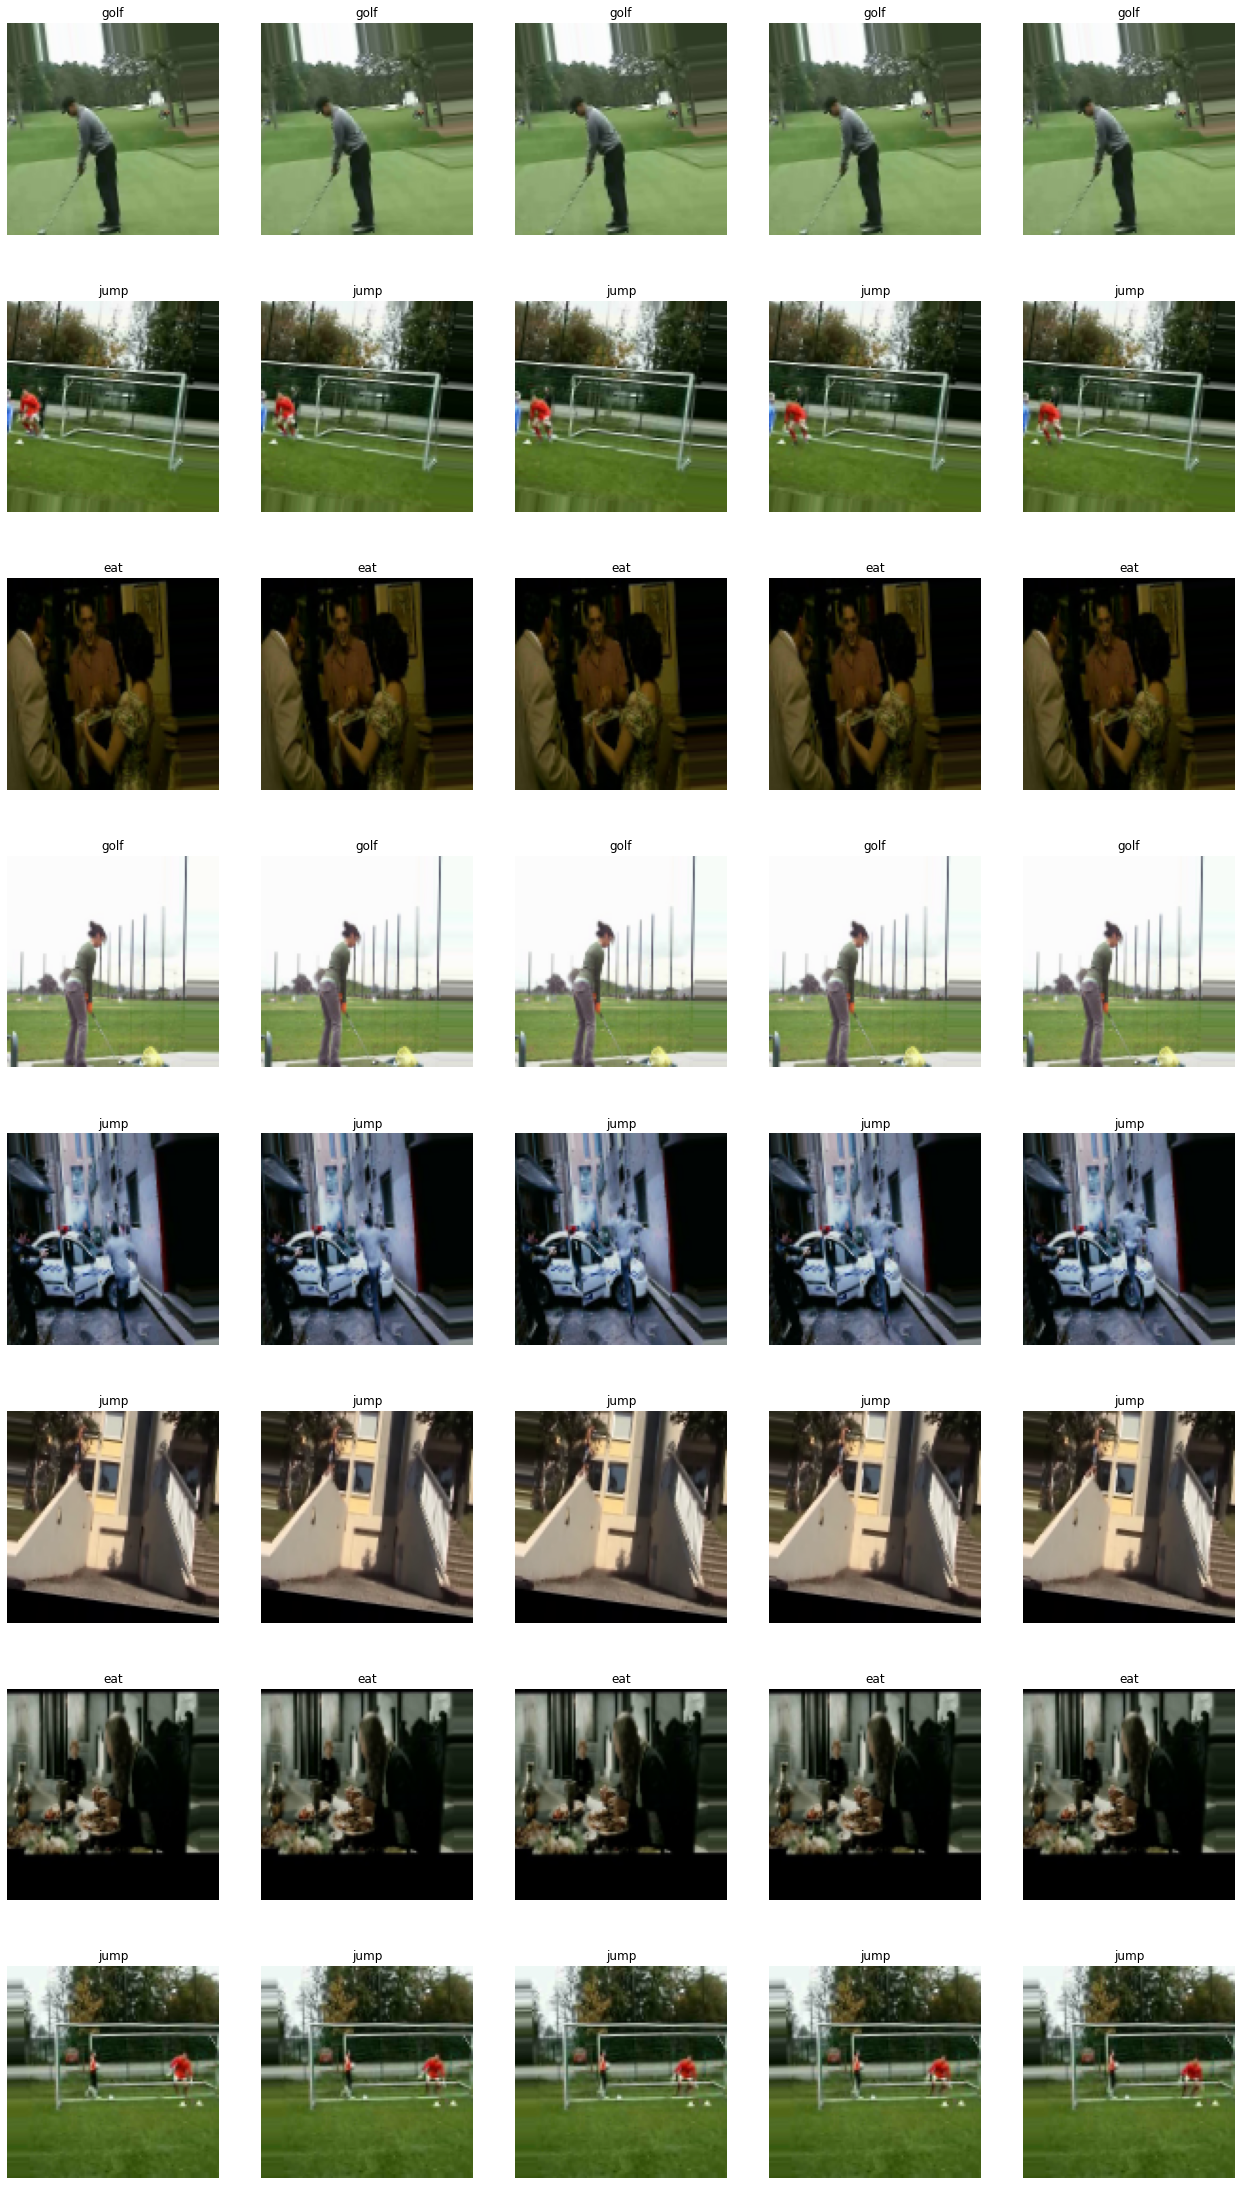

In [10]:
import keras_video.utils
keras_video.utils.show_sample(train)

In [ ]:
from keras.layers import Conv2D, BatchNormalization, \
    MaxPool2D, GlobalMaxPool2D
def build_convnet(shape=(112, 112, 3)):
    momentum = .9
    model = keras.Sequential()
    model.add(Conv2D(64, (3,3), input_shape=shape,
        padding='same', activation='relu'))
    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPool2D()) # shape (64,64,64) for (W,H,C)
    
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPool2D()) # shape (32,32,128) for (W,H,C)
    
    model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPool2D()) # shape (16,16,256) for (W,H,C)
    
    model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum)) # shape (16,16,512) for (W,H,C)
    
    # flatten...
    model.add(GlobalMaxPool2D()) # shape (None,512) 
    return model

In [ ]:
from keras.layers import TimeDistributed, GRU, Dense, Dropout
def action_model(shape=(5, 112, 112, 3), nbout=3):
    # Create our convnet with (112, 112, 3) input shape
    convnet = build_convnet(shape[1:])
    
    # then create our final model
    model = keras.Sequential()
    # add the convnet with (5, 112, 112, 3) shape
    model.add(TimeDistributed(convnet, input_shape=shape)) # output (None,5,512) for (batchsize,seq_length,num_features)
    # here, you can also use GRU or LSTM
    model.add(GRU(64))
    # and finally, we make a decision network
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(nbout, activation='softmax'))
    return model

In [ ]:
INSHAPE=(NBFRAME,) + SIZE + (CHANNELS,) # (5, 112, 112, 3)
model = action_model(INSHAPE, len(classes))
optimizer = keras.optimizers.Adam(0.001)
model.compile(
    optimizer,
    'categorical_crossentropy',
    metrics=['acc']
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 5, 512)           4689216   
 ibuted)                                                         
                                                                 
 gru (GRU)                   (None, 64)                110976    
                                                                 
 dense (Dense)               (None, 1024)              66560     
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                      

In [ ]:
EPOCHS=1
# create a "chkp" directory before to run that
# because ModelCheckpoint will write models inside
callbacks = [
    keras.callbacks.ReduceLROnPlateau(verbose=1),
    keras.callbacks.ModelCheckpoint(
        '/content/seq_prediction/chkp/weights.{epoch:02d}-{val_loss:.2f}.hdf5',
        verbose=1),
]


In [ ]:

model.fit(
    train,
    validation_data=valid,
    verbose=1,
    epochs=EPOCHS,
    callbacks=callbacks
)